## Fashion Data EDA

In [130]:
import pandas as pd
import numpy as np
import gzip
import math
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import defaultdict
import regex as re
from dateutil.parser import parse

In [131]:
runway_data = 'renttherunway_final_data.json.gz'
modcloth_data = 'modcloth_final_data.json.gz'

In [132]:
def parseData(fname):
    '''
    Parse in the data from the file path/link
    '''
    total = 0
    for l in gzip.open(fname):
        try:
            yield eval(l)
        except NameError:
            total += 1
            print(f"Scrapping Data, Null Entry: {total}")

In [133]:
runway = list(parseData(runway_data))
modcloth = list(parseData(modcloth_data)) #could we use modcloth as a test set?

Scrapping Data, Null Entry: 1
Scrapping Data, Null Entry: 2
Scrapping Data, Null Entry: 3
Scrapping Data, Null Entry: 4
Scrapping Data, Null Entry: 5
Scrapping Data, Null Entry: 6
Scrapping Data, Null Entry: 7
Scrapping Data, Null Entry: 8
Scrapping Data, Null Entry: 9
Scrapping Data, Null Entry: 10
Scrapping Data, Null Entry: 11
Scrapping Data, Null Entry: 12
Scrapping Data, Null Entry: 13
Scrapping Data, Null Entry: 14
Scrapping Data, Null Entry: 15
Scrapping Data, Null Entry: 16
Scrapping Data, Null Entry: 17
Scrapping Data, Null Entry: 18
Scrapping Data, Null Entry: 19
Scrapping Data, Null Entry: 20
Scrapping Data, Null Entry: 21
Scrapping Data, Null Entry: 22
Scrapping Data, Null Entry: 23
Scrapping Data, Null Entry: 24
Scrapping Data, Null Entry: 25
Scrapping Data, Null Entry: 26
Scrapping Data, Null Entry: 27
Scrapping Data, Null Entry: 28
Scrapping Data, Null Entry: 29
Scrapping Data, Null Entry: 30
Scrapping Data, Null Entry: 31
Scrapping Data, Null Entry: 32
Scrapping Data, N

### Cleaning

In [134]:
def bustSplitter(s):
    '''
    Split our bust measurement into measurement and cup size.
    '''
    bust = s[:2]
    cup = s[2:]
    return int(bust), cup

In [135]:
#how many entries are missing bust size
unusable_data = 0
columns = set(list(runway[0].keys()))
for review in runway:
    if len(set(list(review.keys())).intersection(columns)) < len(columns):
        unusable_data += 1
unusable_data

46081

In [136]:
#split bust into measurement and cup size
data = []
for review in runway:
    if len(set(list(review.keys())).intersection(columns)) < len(columns): 
        #if they're missing a column
        continue
    review['bust'], review['cup'] = bustSplitter(review['bust size']) 
    data.append(review)

In [137]:
len(data), len(runway) #dropped around 2000 entries

(146381, 192462)

In [138]:
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016',
 'bust': 34,
 'cup': 'd'}

In [139]:
for d in data:
    d['weight'] = int(re.sub("[^0-9]", "", d['weight']))
    d['rating'] = int(d['rating'])
    d['size'] = int(d['size'])
    d['age'] = int(d['age'])
    d['review_date'] = parse(d['review_date'])
    heights = [int(num.strip('\'').strip('\"')) for num in d['height'].split()]
    d['height'] = (heights[0] * 12) + heights[1]

In [140]:
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': 137,
 'rating': 10,
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': 68,
 'size': 14,
 'age': 28,
 'review_date': datetime.datetime(2016, 4, 20, 0, 0),
 'bust': 34,
 'cup': 'd'}

### EDA

In [141]:
fashion_df = pd.DataFrame(data)

In [142]:
fashion_df[['weight', 'height', 'rating', 'bust', 'size', 'age']].describe()
#looks like rating is 5 stars, but prof multlied it by two to include half star ratings
#why do we have ages of 0? sizes of 0? are there people who weigh 50lbs?

,weight,height,rating,bust,size,age
count,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000
mean,137.209870,65.263053,9.081985,34.110738,11.437919,34.089800
std,21.540182,2.659230,1.437853,1.701981,7.826784,8.113217
min,50.000000,54.000000,2.000000,28.000000,0.000000,0.000000
25%,123.000000,63.000000,8.000000,32.000000,4.000000,29.000000
50%,135.000000,65.000000,10.000000,34.000000,9.000000,32.000000
75%,148.000000,67.000000,10.000000,36.000000,16.000000,37.000000
max,300.000000,78.000000,10.000000,48.000000,58.000000,117.000000


<AxesSubplot:xlabel='weight', ylabel='Density'>

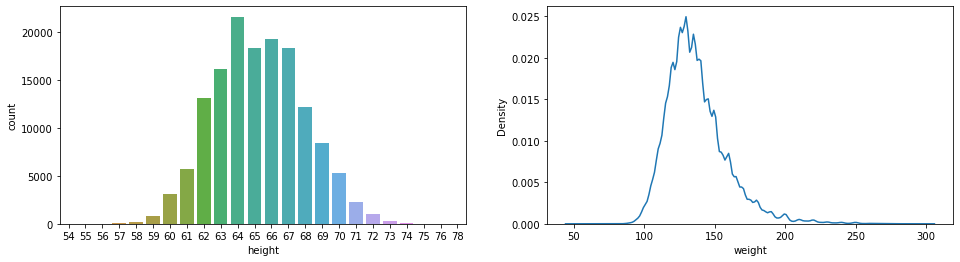

In [143]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
sns.countplot(data = fashion_df, x = 'height', ax = axes[0])
sns.kdeplot(data = fashion_df, x = 'weight', ax = axes[1])

<AxesSubplot:xlabel='rating', ylabel='count'>

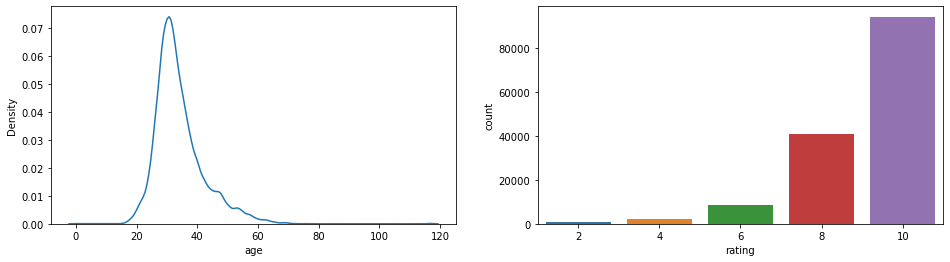

In [144]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
sns.kdeplot(data = fashion_df, x = 'age', ax = axes[0])
sns.countplot(data = fashion_df, x = 'rating', ax = axes[1])

<AxesSubplot:xlabel='fit', ylabel='count'>

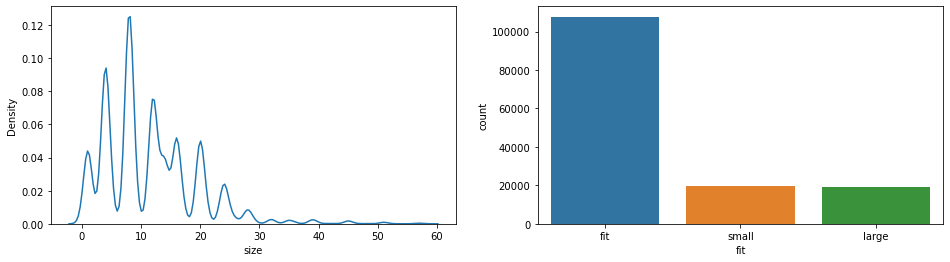

In [145]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
sns.kdeplot(data = fashion_df, x = 'size', ax = axes[0])
sns.countplot(data = fashion_df, x = 'fit', ax = axes[1])

<AxesSubplot:xlabel='body type', ylabel='count'>

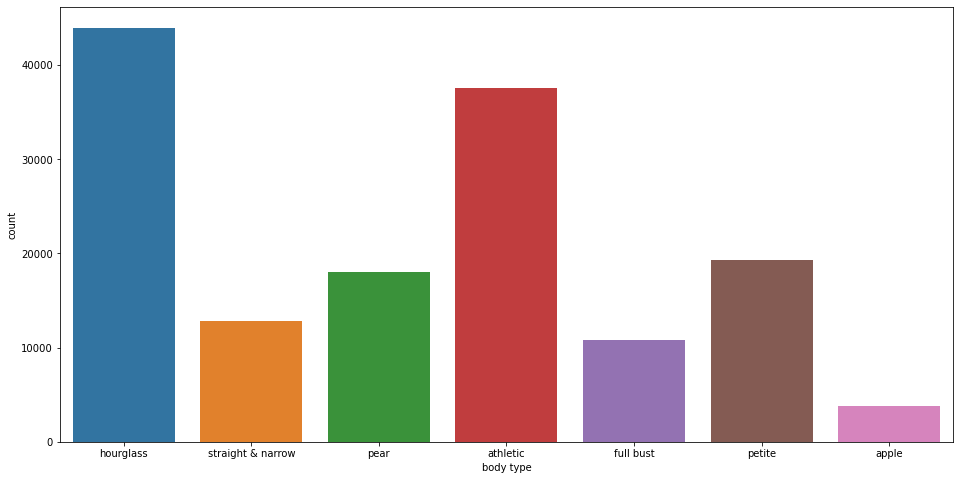

In [146]:
fig, axes = plt.subplots(ncols = 1, figsize = (16, 8))
sns.countplot(data = fashion_df, x = 'body type', ax = axes)

<AxesSubplot:xlabel='bust', ylabel='count'>

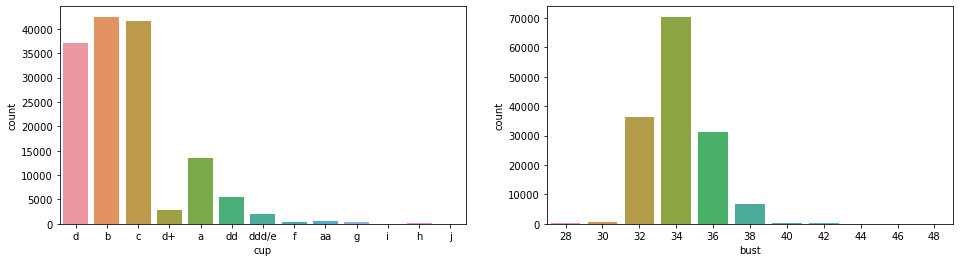

In [147]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 4))
sns.countplot(data = fashion_df, x = 'cup', ax = axes[0])
sns.countplot(data = fashion_df, x = 'bust', ax = axes[1])

In [148]:
fashion_df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,bust,cup
0,fit,420272,34d,2260466,137,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68,14,28,2016-04-20,34,d
1,fit,273551,34b,153475,132,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66,12,36,2013-06-18,34,b
2,fit,909926,34c,126335,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65,8,34,2014-02-12,34,c
3,fit,151944,34b,616682,145,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69,12,27,2016-09-26,34,b
4,fit,734848,32b,364092,138,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68,8,45,2016-04-30,32,b


<AxesSubplot:xlabel='rating', ylabel='bust'>

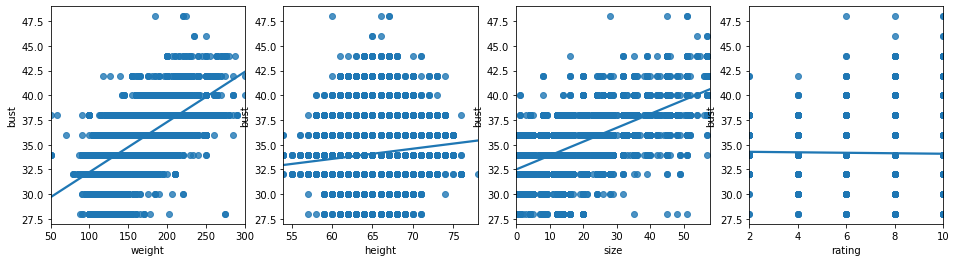

In [149]:
fig, axes = plt.subplots(ncols = 4, figsize = (16, 4))
sns.regplot(data = fashion_df, x = 'weight', y = 'bust', ax = axes[0])
sns.regplot(data = fashion_df, x = 'height', y = 'bust', ax = axes[1])
sns.regplot(data = fashion_df, x = 'size', y = 'bust', ax = axes[2])
sns.regplot(data = fashion_df, x = 'rating', y = 'bust', ax = axes[3])

### Basic Linear Model

In [150]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [151]:
mod = LinearRegression()

In [152]:
train, test = train_test_split(fashion_df, test_size = 0.2, random_state = 200)

In [153]:
train_X, train_Y = train[['weight', 'size', 'height', 'age', 'rating']], train['bust']
test_X, test_Y = test[['weight', 'size', 'height', 'age', 'rating']], test['bust']

In [154]:
mod.fit(train_X, train_Y)

LinearRegression()

In [155]:
preds = mod.predict(test_X)
preds = [round(pred) for pred in preds]

In [156]:
sum([1 if p == a else 0 for p, a in zip(preds, test_Y)])/len(preds)

0.30576903371247055

In [157]:
mean_squared_error(preds, test_Y)

1.616251665129624

### Add some more features

In [158]:
import xgboost as xgb
boost =xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=4,                                                                   
    subsample=0.8
) 

In [159]:
# logisitic and linear models for prediction 
mod = LinearRegression()
mod2 = LogisticRegression()
mod_cup = LinearRegression()
mod2_cup = LogisticRegression()

In [160]:
as_is = ['weight', 'size', 'height', 'age', 'rating']
ohe = ['rented for', 'body type', 'category']

In [161]:
ct = ColumnTransformer(
    [("as_is", FunctionTransformer(lambda x: x), as_is),
    ("ohe", OneHotEncoder(handle_unknown = 'ignore'), ohe)]
)

In [162]:
#we use two models, linear and logisitic regression, both work alot better when we make the bust size ordinal rather than numerical
# i also did the same for cup prediction as well
pl = Pipeline(steps = [('transform', ct), ('Linregression', mod)])
pl2 = Pipeline(steps = [('transform', ct), ('Logregression', mod2)])
pl_cup = Pipeline(steps = [('transform', ct), ('Linregression', mod_cup)])
pl2_cup = Pipeline(steps = [('transform', ct), ('Logregression', mod2_cup)])

In [163]:
def cup_category(cup):
     #encodes cup size into classes 1-12
    if cup == "aa":
        return 0
    elif cup == "a":
        return 1
    elif cup == "b":
        return 2
    elif cup == "c":
        return 3
    elif cup == "d":
        return 4
    elif cup == "d+":
        return 5
    elif cup == "dd":
        return 6
    elif cup == "ddd/e":
        return 7
    elif cup == "f":
        return 8
    elif cup == "g":
        return 9
    elif cup == "h":
        return 10
    elif cup == "i":
        return 11
    else:
        return 12

In [164]:
train["cup_cat"] = train["cup"].apply(cup_category)
test["cup_cat"] = test["cup"].apply(cup_category)

/tmp/ipykernel_103/3262993617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["cup_cat"] = train["cup"].apply(cup_category)
/tmp/ipykernel_103/3262993617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["cup_cat"] = test["cup"].apply(cup_category)


In [165]:
def bust_category(bust):
    #encodes bust size into classes 1-10
    if bust == 28:
        return 0
    elif bust == 30:
        return 1
    elif bust == 32:
        return 2
    elif bust == 34:
        return 3
    elif bust == 36:
        return 4
    elif bust == 38:
        return 5
    elif bust == 40:
        return 6
    elif bust == 42:
        return 7
    elif bust == 44:
        return 8
    elif bust == 46:
        return 9
    else:
        return 10

In [ ]:
train["bust_cat"] = train["bust"].apply(bust_category)
test["bust_cat"] = test["bust"].apply(bust_category)

In [ ]:
train_X, train_Y = train[['weight', 'size', 'height', 'age', 'rating', 'rented for', 'body type', 'category']], train['bust_cat']
test_X, test_Y = test[['weight', 'size', 'height', 'age', 'rating', 'rented for', 'body type', 'category']], test['bust_cat']

In [ ]:
train_X, train_Y_cup = train[['weight', 'size', 'height', 'age', 'rating', 'rented for', 'body type', 'category']], train['cup_cat']
test_X, test_Y_cup = test[['weight', 'size', 'height', 'age', 'rating', 'rented for', 'body type', 'category']], test['cup_cat']

In [ ]:
pl_cup.fit(train_X, train_Y_cup)
pl2_cup.fit(train_X, train_Y_cup)

In [ ]:
pl_cup.score(test_X,test_Y_cup)

In [ ]:
pl2_cup.score(test_X,test_Y_cup)

In [ ]:
train_X

In [ ]:
pl.fit(train_X, train_Y)

In [ ]:
pl.score(test_X,test_Y)

In [ ]:
pl2.fit(train_X, train_Y)

In [ ]:
pl2.score(test_X,test_Y)

In [ ]:
preds2 = pl2.predict(test_X)
sum([1 if p == a else 0 for p, a in zip(preds2, test_Y)])/len(preds2)

In [ ]:
preds = pl.predict(test_X)
preds = [round(pred) for pred in preds] #no such thing as half size?

In [ ]:
sum([1 if p == a else 0 for p, a in zip(preds, test_Y)])/len(preds)

In [ ]:
preds

In [ ]:
mean_squared_error(preds, test_Y)